In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-movies-dataset


In [2]:
!cp -r /kaggle/input/the-movies-dataset ./dataset

# БЛОК 1: Установка библиотек и настройка директории

In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import pickle
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

OUTPUT_DIR = 'streamlit_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)
DRIVE_PATH = 'dataset/'

# БЛОК 2: Загрузка данных

In [4]:
movies_metadata_df = pd.read_csv(DRIVE_PATH + 'movies_metadata.csv', low_memory=False)
keywords_df = pd.read_csv(DRIVE_PATH + 'keywords.csv')
credits_df = pd.read_csv(DRIVE_PATH + 'credits.csv')
ratings_small_df = pd.read_csv(DRIVE_PATH + 'ratings_small.csv')
links_small_df = pd.read_csv(DRIVE_PATH + 'links_small.csv')

# БЛОК 3: Предобработка movies_metadata_df

In [5]:
def safe_literal_eval(val):
    if pd.isna(val) or not isinstance(val, str):
        return []
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError, TypeError):
        return []

movies_metadata_df['id'] = pd.to_numeric(movies_metadata_df['id'], errors='coerce')
movies_metadata_df.dropna(subset=['id'], inplace=True)
movies_metadata_df['id'] = movies_metadata_df['id'].astype(int)
movies_metadata_df.rename(columns={'id': 'tmdb_id'}, inplace=True)

movies_metadata_df['genres_list'] = movies_metadata_df['genres'].apply(safe_literal_eval)
movies_metadata_df['genres'] = movies_metadata_df['genres_list'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

for col in ['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']:
    movies_metadata_df[col] = pd.to_numeric(movies_metadata_df[col], errors='coerce').fillna(0)

movies_metadata_df['release_date'] = pd.to_datetime(movies_metadata_df['release_date'], errors='coerce')

movies_metadata_df = movies_metadata_df[['tmdb_id', 'title', 'overview', 'genres', 'release_date',
                                         'popularity', 'vote_average', 'vote_count', 'runtime',
                                         'budget', 'revenue', 'poster_path']]
movies_metadata_df['overview'] = movies_metadata_df['overview'].fillna('')

# БЛОК 4: Предобработка keywords_df

In [6]:
keywords_df['id'] = pd.to_numeric(keywords_df['id'], errors='coerce')
keywords_df.dropna(subset=['id'], inplace=True)
keywords_df['id'] = keywords_df['id'].astype(int)
keywords_df.rename(columns={'id': 'tmdb_id'}, inplace=True)
keywords_df['keywords_list'] = keywords_df['keywords'].apply(safe_literal_eval)
keywords_df['keywords'] = keywords_df['keywords_list'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
keywords_df = keywords_df[['tmdb_id', 'keywords']]

# БЛОК 5: Предобработка credits_df



In [7]:
credits_df['id'] = pd.to_numeric(credits_df['id'], errors='coerce')
credits_df.dropna(subset=['id'], inplace=True)
credits_df['id'] = credits_df['id'].astype(int)
credits_df.rename(columns={'id': 'tmdb_id'}, inplace=True)

credits_df['cast_list'] = credits_df['cast'].apply(safe_literal_eval)
credits_df['crew_list'] = credits_df['crew'].apply(safe_literal_eval)

def get_director(crew_list):
    for member in crew_list:
        if member.get('job') == 'Director':
            return member.get('name', '')
    return ''

def get_top_n_cast(cast_list, n=5):
    return [member.get('name', '') for member in cast_list[:n]]

credits_df['director'] = credits_df['crew_list'].apply(get_director)
credits_df['cast'] = credits_df['cast_list'].apply(get_top_n_cast)
credits_df = credits_df[['tmdb_id', 'cast', 'director']]

# БЛОК 6: Предобработка links_small_df



In [8]:
links_small_df['tmdbId'] = pd.to_numeric(links_small_df['tmdbId'], errors='coerce')
links_small_df.dropna(subset=['tmdbId'], inplace=True)
links_small_df['tmdbId'] = links_small_df['tmdbId'].astype('Int64')
links_small_df.rename(columns={'tmdbId': 'tmdb_id', 'movieId': 'movieId_ml'}, inplace=True)
links_small_df = links_small_df[['movieId_ml', 'tmdb_id']]

# БЛОК 7: Предобработка ratings_small_df

In [9]:
ratings_small_df.rename(columns={'movieId': 'movieId_ml'}, inplace=True)
ratings_small_df['movieId_ml'] = ratings_small_df['movieId_ml'].astype('Int64')
ratings_small_df['userId'] = ratings_small_df['userId'].astype('Int64')
ratings_small_df = ratings_small_df[['userId', 'movieId_ml', 'rating', 'timestamp']]

# БЛОК 8: Объединение всех датафреймов



In [10]:
movies_df = movies_metadata_df.merge(keywords_df, on='tmdb_id', how='left')
movies_df = movies_df.merge(credits_df, on='tmdb_id', how='left')

for col in ['keywords', 'cast', 'genres']:
    movies_df[col] = movies_df[col].apply(lambda x: x if isinstance(x, list) else [])
movies_df['director'] = movies_df['director'].fillna('')
movies_df['overview'] = movies_df['overview'].fillna('')

movies_df = movies_df.merge(links_small_df, on='tmdb_id', how='left')
movies_df.drop_duplicates(subset=['tmdb_id'], inplace=True)
movies_df.sort_values(['popularity', 'vote_count'], ascending=[False, False], inplace=True)
movies_df.drop_duplicates(subset=['title'], keep='first', inplace=True)
movies_df.reset_index(drop=True, inplace=True)

valid_movie_ids_ml = movies_df['movieId_ml'].dropna().unique()
ratings_df_filtered = ratings_small_df[ratings_small_df['movieId_ml'].isin(valid_movie_ids_ml)].copy()

# Визуализация

## Визуализация 1: Распределение рейтингов

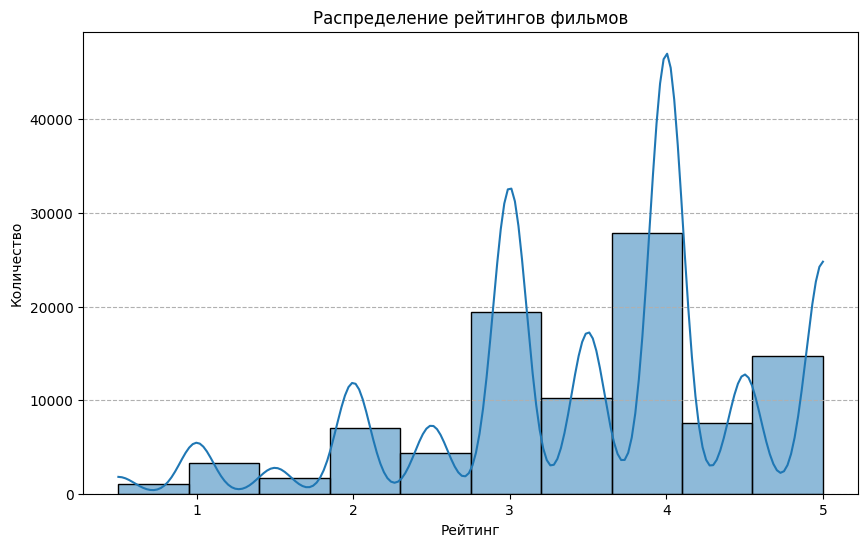

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df_filtered['rating'], bins=10, kde=True)
plt.title('Распределение рейтингов фильмов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--')
plt.savefig(os.path.join(OUTPUT_DIR, 'rating_distribution.png'))
plt.show()

## Визуализация 2: Распределение популярности фильмов

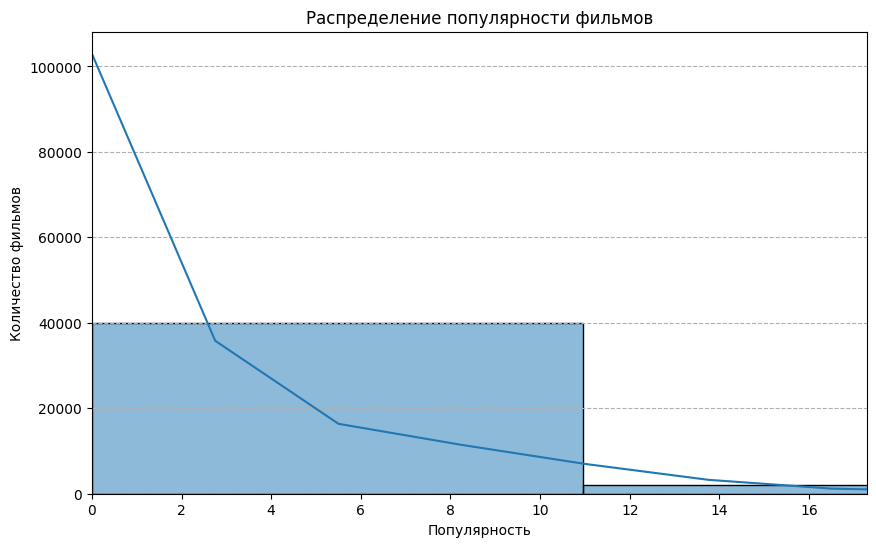

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(movies_df['popularity'], bins=50, kde=True)
plt.title('Распределение популярности фильмов')
plt.xlabel('Популярность')
plt.ylabel('Количество фильмов')
plt.grid(axis='y', linestyle='--')
plt.xlim(0, movies_df['popularity'].quantile(0.99)) # Обрезаем выбросы для лучшей визуализации
plt.savefig(os.path.join(OUTPUT_DIR, 'popularity_distribution.png'))
plt.show()

## Визуализация 3: Распределение количества голосов

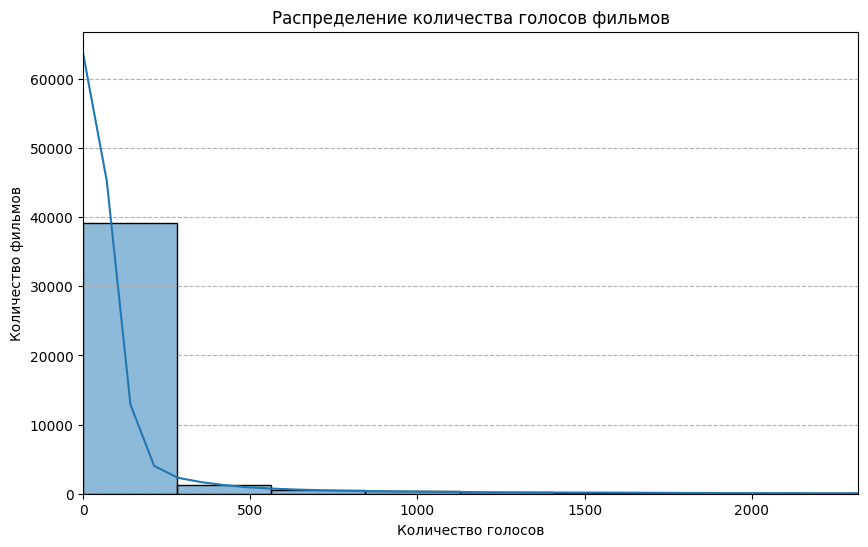

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(movies_df['vote_count'], bins=50, kde=True)
plt.title('Распределение количества голосов фильмов')
plt.xlabel('Количество голосов')
plt.ylabel('Количество фильмов')
plt.grid(axis='y', linestyle='--')
plt.xlim(0, movies_df['vote_count'].quantile(0.99)) # Обрезаем выбросы
plt.savefig(os.path.join(OUTPUT_DIR, 'vote_count_distribution.png'))
plt.show()

## Визуализация 4: Топ-10 наиболее часто встречающихся жанров

C:\Users\Bova\AppData\Local\Temp\ipykernel_23928\2891568729.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


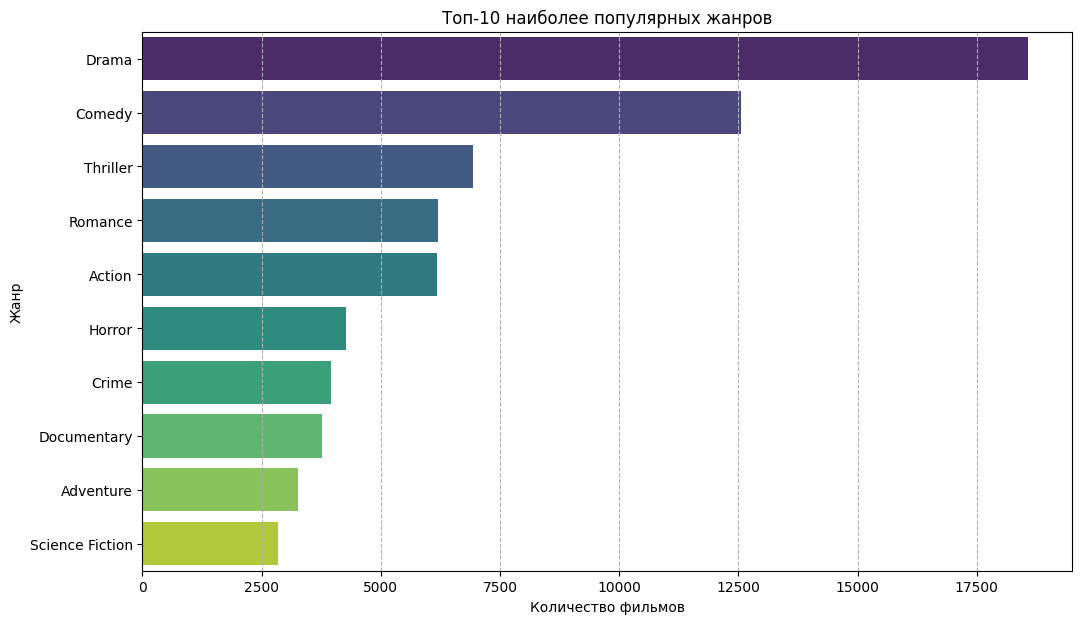

In [14]:
all_genres = [genre for sublist in movies_df['genres'] for genre in sublist]
genres_series = pd.Series(all_genres)
top_genres = genres_series.value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Топ-10 наиболее популярных жанров')
plt.xlabel('Количество фильмов')
plt.ylabel('Жанр')
plt.grid(axis='x', linestyle='--')
plt.savefig(os.path.join(OUTPUT_DIR, 'top_genres.png'))
plt.show()

# БЛОК 9: Content-Based Filtering (CBF) - Feature Engineering и TF-IDF

In [15]:
movies_cb_df = movies_df.copy()

movies_cb_df['genres_str'] = movies_cb_df['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
movies_cb_df['keywords_str'] = movies_cb_df['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
movies_cb_df['cast_str'] = movies_cb_df['cast'].apply(lambda x: ' '.join(member.replace(" ", "") for member in x) if isinstance(x, list) else '')
movies_cb_df['director_str'] = movies_cb_df['director'].apply(lambda x: x.replace(" ", "") if isinstance(x, str) else '')

movies_cb_df['soup'] = movies_cb_df['overview'] + ' ' + \
                       movies_cb_df['genres_str'] + ' ' + \
                       movies_cb_df['keywords_str'] + ' ' + \
                       (movies_cb_df['cast_str'] + ' ') * 3 + \
                       (movies_cb_df['director_str'] + ' ') * 3

movies_cb_df['soup'] = movies_cb_df['soup'].fillna('')

tfidf = TfidfVectorizer(stop_words='english', min_df=3)
tfidf_matrix = tfidf.fit_transform(movies_cb_df['soup'])

cosine_sim_content = cosine_similarity(tfidf_matrix, tfidf_matrix)

cb_indices = pd.Series(movies_cb_df.index, index=movies_cb_df['title']).drop_duplicates()

def get_content_recommendations_demo(title, cosine_sim=cosine_sim_content, movies_data=movies_cb_df, indices_map=cb_indices, top_n=10):
    idx = indices_map[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    recommended_cb_info = movies_data.iloc[movie_indices][['title', 'tmdb_id']].copy()
    full_recommendations = pd.merge(recommended_cb_info,
                                    movies_df[['tmdb_id', 'poster_path', 'overview', 'genres']],
                                    on='tmdb_id', how='left').drop_duplicates(subset=['tmdb_id'])
    ordered_tmdb_ids = recommended_cb_info[recommended_cb_info['tmdb_id'].isin(full_recommendations['tmdb_id'])]['tmdb_id']
    full_recommendations = full_recommendations.set_index('tmdb_id').loc[ordered_tmdb_ids].reset_index()

    return full_recommendations[['title', 'tmdb_id', 'poster_path', 'overview', 'genres']]

# Пример использования (для демонстрации)
example_title_cb = "The Dark Knight Rises"
cbf_recs_df = get_content_recommendations_demo(example_title_cb)
print(f"Пример Content-Based рекомендаций для '{example_title_cb}':")
print(cbf_recs_df[['title', 'tmdb_id']].head(5))

Пример Content-Based рекомендаций для 'The Dark Knight Rises':
                                               title  tmdb_id
0                                    The Dark Knight      155
1                                      Batman Begins      272
2  Batman Unmasked: The Psychology of the Dark Kn...    29751
3                                       The Prestige     1124
4                                     Batman Returns      364


# БЛОК 10: Collaborative Filtering (CF) - Surprise SVD - Обучение



In [16]:
reader = Reader(rating_scale=(0.5, 5.0))
data_surprise = Dataset.load_from_df(ratings_df_filtered[['userId', 'movieId_ml', 'rating']], reader)

trainset = data_surprise.build_full_trainset()

algo_svd = SVD(n_factors=100, n_epochs=30, lr_all=0.005, reg_all=0.04, random_state=42)
algo_svd.fit(trainset)

# БЛОК 11.1: Collaborative Filtering (CF) - Surprise SVD - Оценка

In [17]:
cv_results = cross_validate(algo_svd, data_surprise, measures=['RMSE', 'MAE'], cv=3, verbose=True, n_jobs=-1)

mean_rmse = cv_results['test_rmse'].mean()
mean_mae = cv_results['test_mae'].mean()
svd_evaluation_metrics = {'rmse': mean_rmse, 'mae': mean_mae}

print(f"Средний RMSE по кросс-валидации: {mean_rmse:.4f}")
print(f"Средний MAE по кросс-валидации: {mean_mae:.4f}")

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8985  0.8924  0.8919  0.8943  0.0030  
MAE (testset)     0.6918  0.6858  0.6868  0.6881  0.0027  
Fit time          0.57    0.54    0.49    0.53    0.03    
Test time         0.16    0.13    0.12    0.14    0.02    
Средний RMSE по кросс-валидации: 0.8943
Средний MAE по кросс-валидации: 0.6881


## Визуализация 5: Метрики SVD

C:\Users\Bova\AppData\Local\Temp\ipykernel_23928\395662139.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Метрика', y='Значение', data=metrics_df_svd, palette='mako')


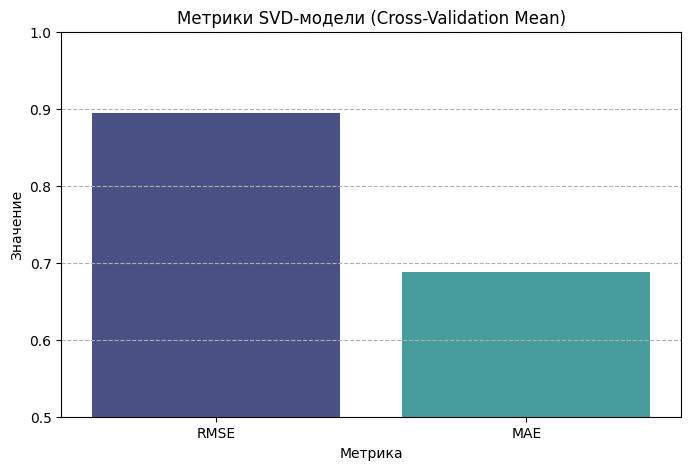

In [18]:
metrics_df_svd = pd.DataFrame({
    'Метрика': ['RMSE', 'MAE'],
    'Значение': [mean_rmse, mean_mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Метрика', y='Значение', data=metrics_df_svd, palette='mako')
plt.title('Метрики SVD-модели (Cross-Validation Mean)')
plt.ylabel('Значение')
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--')
plt.savefig(os.path.join(OUTPUT_DIR, 'svd_metrics.png'))
plt.show()

# БЛОК 11.2: Collaborative Filtering (CF) - Surprise SVD - Оценка

In [19]:
def get_collaborative_recommendations_demo(user_id, algo=algo_svd, movies_data=movies_df, ratings_data=ratings_df_filtered, top_n=10):
    user_id_int = int(user_id)
    user_rated_movies_ml = ratings_data[ratings_data['userId'] == user_id_int]['movieId_ml'].unique()

    all_movies_ml_with_metadata_and_ratings = movies_data[movies_data['movieId_ml'].notna() &
                                                           movies_data['movieId_ml'].isin(ratings_data['movieId_ml'].unique())]['movieId_ml'].unique()

    movies_to_predict_ml = [mid for mid in all_movies_ml_with_metadata_and_ratings if mid not in user_rated_movies_ml]

    predictions = []
    for movie_id_ml in movies_to_predict_ml:
        pred = algo.predict(uid=user_id_int, iid=float(movie_id_ml))
        predictions.append(pred)

    predictions.sort(key=lambda x: x.est, reverse=True)
    top_n_predictions = predictions[:top_n]
    recommended_movie_ids_ml = [pred.iid for pred in top_n_predictions]

    recommended_movies_info = movies_data[movies_data['movieId_ml'].isin(recommended_movie_ids_ml)].copy()
    category_order = pd.CategoricalDtype(recommended_movie_ids_ml, ordered=True)
    recommended_movies_info['movieId_ml_ordered'] = recommended_movies_info['movieId_ml'].astype(category_order)
    recommended_movies_info_sorted = recommended_movies_info.sort_values('movieId_ml_ordered')
    return recommended_movies_info_sorted[['title', 'tmdb_id', 'poster_path', 'overview', 'genres']]


# Пример использования (для демонстрации)
example_user_id_cf = 1
svd_recs_df = get_collaborative_recommendations_demo(example_user_id_cf)
print(f"Пример Collaborative SVD рекомендаций для пользователя ID {example_user_id_cf}:")
print(svd_recs_df[['title', 'tmdb_id', 'genres', 'overview']].head(5).to_string())

Пример Collaborative SVD рекомендаций для пользователя ID 1:
                              title  tmdb_id                                 genres                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              overview
11689                     Tom Jones     5769  [Adventure, Comedy, History, Romance]                                                                                                                                                                                                                                              

# БЛОК 12: Решения для "Холодного старта" - Популярные фильмы

In [24]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.90)

def weighted_rating(df, m=m, C=C):
    v = df['vote_count']
    R = df['vote_average']
    return (v / (v + m) * R) + (m / (v + m) * C)

movies_df['weighted_rating'] = movies_df.apply(weighted_rating, axis=1)
popular_movies_df = movies_df.sort_values('weighted_rating', ascending=False)

def get_popular_movies_demo(top_n=10, movies_data=popular_movies_df):
    return movies_data[['title', 'tmdb_id', 'poster_path', 'overview', 'genres', 'release_date', 'weighted_rating']].head(top_n).copy()

# Для Streamlit
top_popular = get_popular_movies_demo(top_n=50)
print("Топ популярных фильмов (для холодного старта, пример 5):")
print(top_popular[['title', 'tmdb_id', 'weighted_rating']].head())

Топ популярных фильмов (для холодного старта, пример 5):
                          title  tmdb_id  weighted_rating
34     The Shawshank Redemption      278         8.442353
51                The Godfather      238         8.420635
79  Dilwale Dulhania Le Jayenge    19404         8.385749
15              The Dark Knight      155         8.263230
27                   Fight Club      550         8.253557


# БЛОК 13: Решения для "Холодного старта" - Новинки каталога

In [25]:
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')

candidate_movies_for_new = movies_df[
    movies_df['poster_path'].notna() &
    (movies_df['overview'].notna()) & (movies_df['overview'] != '')
].copy()

rated_movie_ids_ml = ratings_df_filtered['movieId_ml'].dropna().unique()
rated_tmdb_ids = movies_df[movies_df['movieId_ml'].isin(rated_movie_ids_ml)]['tmdb_id'].dropna().unique()

new_items_unrated_df = candidate_movies_for_new[
    ~candidate_movies_for_new['tmdb_id'].isin(rated_tmdb_ids)
].copy()

new_items_unrated_df.dropna(subset=['release_date'], inplace=True)

new_items_df_sorted = new_items_unrated_df.sort_values(
    ['release_date', 'weighted_rating', 'popularity'],
    ascending=[False, False, False]
)
top_n_new_items_display = 20
final_new_items_df = new_items_df_sorted.head(top_n_new_items_display)

print("Пример 'новинки' (топ 5):")
print(final_new_items_df[['title', 'release_date', 'popularity', 'weighted_rating']].head(5))

Пример 'новинки' (топ 5):
                            title release_date  popularity  weighted_rating
7315                     Avatar 2   2020-12-16    6.020055         4.205665
34433  The Other Side of the Wind   2018-12-31    0.238154         5.596975
14884           Bad Boys for Life   2018-11-07    2.178546         5.261096
11664                Mary Shelley   2018-04-25    3.328261         5.596975
36144                Mobile Homes   2018-04-04    0.155147         5.596975


# БЛОК 14: Сохранение артефактов для Streamlit

In [26]:
with open(os.path.join(OUTPUT_DIR, 'movies_data.pkl'), 'wb') as f:
    pickle.dump(movies_df, f)

with open(os.path.join(OUTPUT_DIR, 'content_similarity_matrix.pkl'), 'wb') as f:
    pickle.dump(cosine_sim_content, f)

with open(os.path.join(OUTPUT_DIR, 'cb_movie_indices.pkl'), 'wb') as f:
    pickle.dump(cb_indices, f)

with open(os.path.join(OUTPUT_DIR, 'svd_model.pkl'), 'wb') as f:
    pickle.dump(algo_svd, f)

with open(os.path.join(OUTPUT_DIR, 'ratings_data_filtered.pkl'), 'wb') as f:
    pickle.dump(ratings_df_filtered, f)

with open(os.path.join(OUTPUT_DIR, 'popular_movies.pkl'), 'wb') as f:
    pickle.dump(top_popular, f)

with open(os.path.join(OUTPUT_DIR, 'movies_cb_df.pkl'), 'wb') as f:
    pickle.dump(movies_cb_df[['title', 'tmdb_id', 'poster_path', 'overview', 'genres']], f)

with open(os.path.join(OUTPUT_DIR, 'svd_evaluation_metrics.pkl'), 'wb') as f:
    pickle.dump(svd_evaluation_metrics, f)

with open(os.path.join(OUTPUT_DIR, 'new_items_for_cold_start.pkl'), 'wb') as f:
    pickle.dump(final_new_items_df, f)

with open(os.path.join(OUTPUT_DIR, 'tfidf_vectorizer.pkl'), 'wb') as f:
    pickle.dump(tfidf, f)

# БЛОК 15: GNN


## БЛОК 1: Установка библиотек и настройка директории

In [1]:
pip install torch_geometric

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ------------------ --------------------- 0.5/1.1 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 3.1 MB/s eta 0:00:00

   ------------------------------ --------- 6/8 [aiohttp]
   ------------------------------ --------- 6/8 [aiohttp]
   ----------------------------------- ---- 7/8 [torch_geometric]
   ----------------------------------- ---- 7/8 [torch_geometric]
   ----------------------------------- ---- 7/8 [torch_geometric]
   ----------------------------------- ---- 7/8 [torch_geometric]
   ----------------------------------- ---- 7/8 [torch_geometric]
   ----------------------------------- ---- 7/8 [torch_geometric]
   ----------------------------------- ---- 7/8 [torch_geometric]
   ----------------------------------- ---- 7/8 [torch_geometric]
   ---------------------------------------- 8/8 [torch_geometric]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR_GNN = 'streamlit_data_gnn'
os.makedirs(OUTPUT_DIR_GNN, exist_ok=True)
DATA_DIR_ML100K = 'ml-100k/ml-100k/'

## БЛОК 2: Загрузка и базовая предобработка данных MovieLens 100k

In [3]:
ratings_df = pd.read_csv(DATA_DIR_ML100K + 'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
users_df = pd.read_csv(DATA_DIR_ML100K + 'u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

genres = pd.read_csv(DATA_DIR_ML100K + 'u.genre', sep='|', names=['genre_name', 'genre_id'])['genre_name'].tolist()
item_cols = ['item_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
item_cols.extend(genres)

items_df = pd.read_csv(DATA_DIR_ML100K + 'u.item', sep='|', names=item_cols, encoding='latin-1')

FileNotFoundError: [Errno 2] No such file or directory: 'ml-100k/ml-100k/u.data'

## БЛОК 3: Подготовка признаков пользователей и фильмов для GNN

In [ ]:
user_encoder = LabelEncoder()
ratings_df['user_idx'] = user_encoder.fit_transform(ratings_df['user_id'])
users_df['user_idx'] = user_encoder.transform(users_df['user_id'])

item_encoder = LabelEncoder()
ratings_df['item_idx'] = item_encoder.fit_transform(ratings_df['item_id'])
items_df['item_idx'] = item_encoder.transform(items_df['item_id'])

num_users = ratings_df['user_idx'].nunique()
num_items = ratings_df['item_idx'].nunique()

gender_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
gender_encoded = gender_encoder.fit_transform(users_df[['gender']])
gender_df = pd.DataFrame(gender_encoded, columns=gender_encoder.get_feature_names_out(['gender']))

occupation_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
occupation_encoded = occupation_encoder.fit_transform(users_df[['occupation']])
occupation_df = pd.DataFrame(occupation_encoded, columns=occupation_encoder.get_feature_names_out(['occupation']))

age_scaler = StandardScaler()
users_df['age_scaled'] = age_scaler.fit_transform(users_df[['age']])

user_features_df = pd.concat([users_df[['user_idx', 'age_scaled']], gender_df, occupation_df], axis=1)
user_features_df = user_features_df.set_index('user_idx').sort_index()
user_features_df = user_features_df.fillna(0)
user_features_tensor = torch.tensor(user_features_df.values, dtype=torch.float)

plt.figure(figsize=(8, 5))
sns.histplot(users_df['age'], bins=20, kde=True)
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.savefig(os.path.join(OUTPUT_DIR_GNN, 'user_age_distribution.png'))
plt.show()

def extract_year(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str) or len(date_str) < 4:
        return 1950
    try:
        return int(date_str.split('-')[-1])
    except:
        return 1950

items_df['release_year'] = items_df['release_date'].apply(extract_year)
year_scaler = StandardScaler()
items_df['release_year_scaled'] = year_scaler.fit_transform(items_df[['release_year']])

item_genre_features = items_df[genres].values
item_year_feature = items_df[['release_year_scaled']].values

items_features_base_df = items_df[['item_idx']].copy()
items_features_base_df['release_year_scaled'] = item_year_feature
for i, genre_name in enumerate(genres):
    items_features_base_df[genre_name] = item_genre_features[:, i]

items_features_df = items_features_base_df.set_index('item_idx').sort_index()
items_features_df = items_features_df.fillna(0)
item_features_tensor = torch.tensor(items_features_df.values, dtype=torch.float)

plt.figure(figsize=(10, 6))
sns.histplot(items_df['release_year'], bins=30, kde=True)
plt.title('Распределение годов выпуска фильмов')
plt.xlabel('Год выпуска')
plt.ylabel('Количество')
plt.savefig(os.path.join(OUTPUT_DIR_GNN, 'movie_release_year_distribution.png'))
plt.show()

## БЛОК 4: Разделение данных и создание графа для GNN

In [ ]:
train_ratings_df = pd.read_csv(DATA_DIR_ML100K + 'u1.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
test_ratings_df = pd.read_csv(DATA_DIR_ML100K + 'u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

train_ratings_df['user_idx'] = user_encoder.transform(train_ratings_df['user_id'])
train_ratings_df['item_idx'] = item_encoder.transform(train_ratings_df['item_id'])
test_ratings_df['user_idx'] = user_encoder.transform(test_ratings_df['user_id'])
test_ratings_df['item_idx'] = item_encoder.transform(test_ratings_df['item_id'])

train_src = torch.tensor(train_ratings_df['user_idx'].values, dtype=torch.long)
train_dst = torch.tensor(train_ratings_df['item_idx'].values, dtype=torch.long)
train_edge_index = torch.stack([train_src, train_dst], dim=0)

test_src = torch.tensor(test_ratings_df['user_idx'].values, dtype=torch.long)
test_dst = torch.tensor(test_ratings_df['item_idx'].values, dtype=torch.long)
test_pos_edge_index = torch.stack([test_src, test_dst], dim=0)

train_pos_pairs = set(tuple(x) for x in train_ratings_df[['user_idx', 'item_idx']].values)

data_gnn = Data(
    num_users=num_users,
    num_items=num_items,
    train_pos_edge_index=train_edge_index
)


## БЛОК 5: Реализация GNN модели

In [ ]:
class GNNRecommender(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, user_feature_dim, item_feature_dim, hidden_channels, num_layers=2, use_features=True):
        super().__init__()
        self.use_features = use_features
        self.num_users = num_users
        self.num_items = num_items

        self.user_id_emb = nn.Embedding(num_users, embedding_dim)
        self.item_id_emb = nn.Embedding(num_items, embedding_dim)

        gnn_input_dim = embedding_dim * 2 if self.use_features else embedding_dim
        if self.use_features:
            self.user_feat_proj = nn.Linear(user_feature_dim, embedding_dim)
            self.item_feat_proj = nn.Linear(item_feature_dim, embedding_dim)

        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(gnn_input_dim, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        self.final_user_emb_dim = hidden_channels
        self.final_item_emb_dim = hidden_channels

    def get_initial_embeddings(self, user_indices, item_indices, user_features, item_features):
        user_id_embs = self.user_id_emb(user_indices)
        item_id_embs = self.item_id_emb(item_indices)

        if self.use_features:
            user_feat_embs = self.user_feat_proj(user_features[user_indices])
            item_feat_embs = self.item_feat_proj(item_features[item_indices])
            user_embs = torch.cat([user_id_embs, user_feat_embs], dim=1)
            item_embs = torch.cat([item_id_embs, item_feat_embs], dim=1)
        else:
            user_embs = user_id_embs
            item_embs = item_id_embs
        return user_embs, item_embs

    def encode(self, x_user_initial, x_item_initial, edge_index):
        x_user = x_user_initial
        x_item = x_item_initial

        for conv in self.convs:
            x_item_new = conv((x_user, x_item), edge_index)
            x_item_new = F.relu(x_item_new)
            x_item_new = F.dropout(x_item_new, p=0.5, training=self.training)

            reversed_edge_index = edge_index[[1, 0]]
            x_user_new = conv((x_item, x_user), reversed_edge_index)
            x_user_new = F.relu(x_user_new)
            x_user_new = F.dropout(x_user_new, p=0.5, training=self.training)

            x_user, x_item = x_user_new, x_item_new
        return x_user, x_item

    def decode(self, user_embedding, item_embedding):
        return (user_embedding * item_embedding).sum(dim=-1)

    def forward(self, user_indices_batch, item_indices_pos_batch, item_indices_neg_batch,
                all_user_features, all_item_features, graph_edge_index):

        all_user_graph_indices = torch.arange(self.num_users, device=user_indices_batch.device)
        all_item_graph_indices = torch.arange(self.num_items, device=user_indices_batch.device)

        x_user_initial, x_item_initial = self.get_initial_embeddings(
            all_user_graph_indices,
            all_item_graph_indices,
            all_user_features,
            all_item_features
        )

        user_embs_final, item_embs_final = self.encode(x_user_initial, x_item_initial, graph_edge_index)

        user_emb_batch = user_embs_final[user_indices_batch]
        item_emb_pos_batch = item_embs_final[item_indices_pos_batch]
        item_emb_neg_batch = item_embs_final[item_indices_neg_batch]

        pos_score = self.decode(user_emb_batch, item_emb_pos_batch)
        neg_score = self.decode(user_emb_batch, item_emb_neg_batch)

        return pos_score, neg_score

EMBEDDING_DIM = 32
HIDDEN_CHANNELS = 64
NUM_GNN_LAYERS = 2
USE_NODE_FEATURES = True

model_gnn = GNNRecommender(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=EMBEDDING_DIM,
    user_feature_dim=user_features_tensor.shape[1],
    item_feature_dim=item_features_tensor.shape[1],
    hidden_channels=HIDDEN_CHANNELS,
    num_layers=NUM_GNN_LAYERS,
    use_features=USE_NODE_FEATURES
)

model_gnn = model_gnn.to(device)
user_features_tensor = user_features_tensor.to(device)
item_features_tensor = item_features_tensor.to(device)
train_graph_edge_index = data_gnn.train_pos_edge_index.to(device)

optimizer_gnn = optim.Adam(model_gnn.parameters(), lr=0.001)

def bpr_loss(pos_scores, neg_scores):
    return -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-9).mean()

def sample_negative_edges(positive_user_indices, num_items, num_negative_samples=1):
    users = positive_user_indices
    batch_size = len(users)
    neg_items = []
    for i in range(batch_size):
        user = users[i].item()
        for _ in range(num_negative_samples):
            while True:
                neg_item_candidate = np.random.randint(0, num_items)
                if (user, neg_item_candidate) not in train_pos_pairs:
                    neg_items.append(neg_item_candidate)
                    break
    return torch.tensor(neg_items, dtype=torch.long, device=users.device)

## БЛОК 6: Обучение GNN модели


In [ ]:
EPOCHS = 50
BATCH_SIZE = 1024

model_gnn.train()
loss_history = []

for epoch in range(EPOCHS):
    total_loss = 0
    perm = torch.randperm(data_gnn.train_pos_edge_index.size(1))
    shuffled_train_pos_edge_index = data_gnn.train_pos_edge_index[:, perm]

    for i in range(0, shuffled_train_pos_edge_index.size(1), BATCH_SIZE):
        optimizer_gnn.zero_grad()
        batch_pos_edge_index = shuffled_train_pos_edge_index[:, i:i+BATCH_SIZE].to(device)
        batch_user_indices = batch_pos_edge_index[0]
        batch_item_indices_pos = batch_pos_edge_index[1]

        batch_item_indices_neg = sample_negative_edges(batch_user_indices, num_items, 1)

        pos_scores, neg_scores = model_gnn(batch_user_indices,
                                           batch_item_indices_pos,
                                           batch_item_indices_neg,
                                           user_features_tensor,
                                           item_features_tensor,
                                           train_graph_edge_index)
        loss = bpr_loss(pos_scores, neg_scores)
        loss.backward()
        optimizer_gnn.step()
        total_loss += loss.item() * batch_user_indices.size(0)

    avg_loss = total_loss / data_gnn.train_pos_edge_index.size(1)
    loss_history.append(avg_loss)
    print(f"Эпоха {epoch+1}/{EPOCHS}, Средняя BPR Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(loss_history, marker='o', linestyle='-', color='skyblue', label='BPR Loss')
plt.title('Динамика BPR Loss во время обучения GNN')
plt.xlabel('Эпоха')
plt.ylabel('Средняя BPR Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR_GNN, 'gnn_bpr_loss_history.png'))
plt.show()

## БЛОК 7: Оценка GNN модели

In [ ]:
@torch.no_grad()
def evaluate_gnn(model, test_pos_edge_index, train_pos_edge_index, all_user_features, all_item_features,
             num_users, num_items, K=20):
    model.eval()

    all_user_graph_indices = torch.arange(num_users, device=device)
    all_item_graph_indices = torch.arange(num_items, device=device)

    x_user_initial, x_item_initial = model.get_initial_embeddings(
        all_user_graph_indices,
        all_item_graph_indices,
        all_user_features,
        all_item_features
    )
    user_embs_final, item_embs_final = model.encode(x_user_initial, x_item_initial, train_pos_edge_index)

    recalls = []
    precisions = []
    ndcgs = []

    test_user_items = defaultdict(list)
    for i in range(test_pos_edge_index.shape[1]):
        user = test_pos_edge_index[0, i].item()
        item = test_pos_edge_index[1, i].item()
        test_user_items[user].append(item)

    train_user_items = defaultdict(list)
    for i in range(train_pos_edge_index.shape[1]):
        user = train_pos_edge_index[0, i].item()
        item = train_pos_edge_index[1, i].item()
        train_user_items[user].append(item)

    test_users = sorted(list(test_user_items.keys()))

    for user_idx in test_users:
        user_emb = user_embs_final[user_idx].unsqueeze(0)
        scores = model.decode(user_emb, item_embs_final).squeeze()

        if user_idx in train_user_items:
            seen_items = train_user_items[user_idx]
            scores[seen_items] = -np.inf

        top_k_scores, top_k_indices = torch.topk(scores, K)
        recommended_items = top_k_indices.cpu().numpy()

        true_items = test_user_items[user_idx]

        hits = set(recommended_items) & set(true_items)

        precision = len(hits) / K
        precisions.append(precision)

        recall = len(hits) / len(true_items) if len(true_items) > 0 else 0
        recalls.append(recall)

        relevance = np.zeros(K)
        for i, item_id in enumerate(recommended_items):
            if item_id in true_items:
                relevance[i] = 1

        dcg = np.sum(relevance / np.log2(np.arange(2, K + 2)))
        num_true_relevant = min(K, len(true_items))
        idcg_relevance = np.zeros(K)
        idcg_relevance[:num_true_relevant] = 1
        idcg = np.sum(idcg_relevance / np.log2(np.arange(2, K + 2)))

        ndcg = dcg / idcg if idcg > 0 else 0
        ndcgs.append(ndcg)

    avg_recall = np.mean(recalls)
    avg_precision = np.mean(precisions)
    avg_ndcg = np.mean(ndcgs)

    return avg_recall, avg_precision, avg_ndcg

K_EVAL_GNN = 20
recall_at_k_gnn, precision_at_k_gnn, ndcg_at_k_gnn = evaluate_gnn(
    model_gnn,
    test_pos_edge_index.to(device),
    data_gnn.train_pos_edge_index.to(device),
    user_features_tensor,
    item_features_tensor,
    num_users,
    num_items,
    K=K_EVAL_GNN
)

print(f"Результаты оценки GNN на тестовой выборке (K={K_EVAL_GNN}):")
print(f"  Recall@{K_EVAL_GNN}: {recall_at_k_gnn:.4f}")
print(f"  Precision@{K_EVAL_GNN}: {precision_at_k_gnn:.4f}")
print(f"  NDCG@{K_EVAL_GNN}: {ndcg_at_k_gnn:.4f}")

gnn_eval_metrics = {
    f'recall_at_{K_EVAL_GNN}': recall_at_k_gnn,
    f'precision_at_{K_EVAL_GNN}': precision_at_k_gnn,
    f'ndcg_at_{K_EVAL_GNN}': ndcg_at_k_gnn
}

metrics_df_gnn = pd.DataFrame({
    'Метрика': [f'Recall@{K_EVAL_GNN}', f'Precision@{K_EVAL_GNN}', f'NDCG@{K_EVAL_GNN}'],
    'Значение': [recall_at_k_gnn, precision_at_k_gnn, ndcg_at_k_gnn]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Метрика', y='Значение', data=metrics_df_gnn, palette='rocket')
plt.title(f'Метрики GNN-модели на тестовой выборке (K={K_EVAL_GNN})')
plt.ylabel('Значение')
plt.ylim(0.0, 0.5)
plt.grid(axis='y', linestyle='--')
plt.savefig(os.path.join(OUTPUT_DIR_GNN, 'gnn_evaluation_metrics.png'))
plt.show()

## БЛОК 8: Сохранение GNN артефактов для Streamlit

In [ ]:
with open(os.path.join(OUTPUT_DIR_GNN, 'gnn_model.pkl'), 'wb') as f:
    pickle.dump(model_gnn, f)

with open(os.path.join(OUTPUT_DIR_GNN, 'gnn_user_features.pkl'), 'wb') as f:
    pickle.dump(user_features_tensor.cpu(), f)

with open(os.path.join(OUTPUT_DIR_GNN, 'gnn_item_features.pkl'), 'wb') as f:
    pickle.dump(item_features_tensor.cpu(), f)

with open(os.path.join(OUTPUT_DIR_GNN, 'gnn_train_edge_index.pkl'), 'wb') as f:
    pickle.dump(data_gnn.train_pos_edge_index.cpu(), f)

with open(os.path.join(OUTPUT_DIR_GNN, 'gnn_user_encoder.pkl'), 'wb') as f:
    pickle.dump(user_encoder, f)

with open(os.path.join(OUTPUT_DIR_GNN, 'gnn_item_encoder.pkl'), 'wb') as f:
    pickle.dump(item_encoder, f)

with open(os.path.join(OUTPUT_DIR_GNN, 'gnn_evaluation_metrics.pkl'), 'wb') as f:
    pickle.dump(gnn_eval_metrics, f)

items_df.to_pickle(os.path.join(OUTPUT_DIR_GNN, 'gnn_items_df.pkl'))
ratings_df.to_pickle(os.path.join(OUTPUT_DIR_GNN, 'gnn_ratings_df.pkl'))

print(f"Все необходимые артефакты GNN сохранены в папку: {OUTPUT_DIR_GNN}")
for item in os.listdir(OUTPUT_DIR_GNN):
    print(f"- {item}")